In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn import metrics
import pydotplus

In [2]:
# Bring in modeling dataframe with users and features representing past purchases by dept
df = pd.read_csv('modeling_dfs/users_order_by_prev_dept.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)

#join a dataframe with info on organic_produce specifically
df_org_produce = pd.read_csv('modeling_dfs/users_order_by_prev_org.csv')
df_org_produce.drop(['Unnamed: 0'],axis=1,inplace=True)
df = df.merge(df_org_produce[['order_id','organic_produce','any_organic_produce',
                              'organic_non_produce','any_organic_non_produce',
                              'organic_produce_prev','any_organic_produce_prev']],on='order_id')
display(df[['organic','organic_produce']].sample(10)) #sanity check for join because any_organic_produce should always be less

#join a dataframe with historical produce buying
df_hist_org = pd.read_csv('modeling_dfs/users_hist_org.csv')
df_hist_org=df_hist_org.rename(columns = {'organic':'hist_organic','organic_produce':'hist_organic_produce'})
df_hist_org['any_hist_organic'] = df_hist_org['hist_organic']>0
df_hist_org['any_hist_organic_produce'] = df_hist_org['hist_organic_produce']>0
df_hist_org.sample(20)

df = df.merge(df_hist_org,on='user_id')
display(df.head(5))
display(len(df))

,organic,organic_produce
75547,14.0,7.0
3696,5.0,2.0
109267,3.0,3.0
20343,0.0,0.0
32615,10.0,3.0
96668,1.0,0.0
3340,0.0,0.0
95078,3.0,2.0
120688,0.0,0.0
38491,2.0,0.0


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_id_order,user_id_prevorder,order_id_prev,...,organic_produce,any_organic_produce,organic_non_produce,any_organic_non_produce,organic_produce_prev,any_organic_produce_prev,hist_organic,hist_organic_produce,any_hist_organic,any_hist_organic_produce
0,1187899,1,train,11,4,8,14.0,1.011,1.010,2550362.0,...,0.0,False,3.0,True,0,False,6,2,True,True
1,1492625,2,train,15,1,11,30.0,2.015,2.014,839880.0,...,1.0,True,5.0,True,3,True,28,9,True,True
2,2196797,5,train,5,0,11,6.0,5.005,5.004,157374.0,...,3.0,True,2.0,True,3,True,12,7,True,True
3,525192,7,train,21,2,11,6.0,7.021,7.020,2452257.0,...,0.0,False,1.0,True,3,True,27,11,True,True
4,880375,8,train,4,1,14,10.0,8.004,8.003,2570360.0,...,7.0,True,2.0,True,2,True,15,8,True,True


131209

# Feature engineering and testing

In [3]:
# bin continuous variable column "days since prior order" into a categorical variable
df['bins_prior_order_days'] = pd.cut(df['days_since_prior_order'],bins=[-0.5,4.5,8.5,15.5,22.5,30.5])
display(df['bins_prior_order_days'].head())
df[['days_since_0-4','days_since_5-8','days_since_9-15','days_since_16-22','days_since_23-30']] = \
    pd.get_dummies(df['bins_prior_order_days'])
display(df.head())

0     (8.5, 15.5]
1    (22.5, 30.5]
2      (4.5, 8.5]
3      (4.5, 8.5]
4     (8.5, 15.5]
Name: bins_prior_order_days, dtype: category
Categories (5, interval[float64]): [(-0.5, 4.5] < (4.5, 8.5] < (8.5, 15.5] < (15.5, 22.5] < (22.5, 30.5]]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_id_order,user_id_prevorder,order_id_prev,...,hist_organic,hist_organic_produce,any_hist_organic,any_hist_organic_produce,bins_prior_order_days,days_since_0-4,days_since_5-8,days_since_9-15,days_since_16-22,days_since_23-30
0,1187899,1,train,11,4,8,14.0,1.011,1.010,2550362.0,...,6,2,True,True,"(8.5, 15.5]",0,0,1,0,0
1,1492625,2,train,15,1,11,30.0,2.015,2.014,839880.0,...,28,9,True,True,"(22.5, 30.5]",0,0,0,0,1
2,2196797,5,train,5,0,11,6.0,5.005,5.004,157374.0,...,12,7,True,True,"(4.5, 8.5]",0,1,0,0,0
3,525192,7,train,21,2,11,6.0,7.021,7.020,2452257.0,...,27,11,True,True,"(4.5, 8.5]",0,1,0,0,0
4,880375,8,train,4,1,14,10.0,8.004,8.003,2570360.0,...,15,8,True,True,"(8.5, 15.5]",0,0,1,0,0


In [4]:
#transform order characteristics into more interpretable features based on shopping tendencies
df['morning'] = df['order_hour_of_day'].apply(lambda x: True if ((x>=4) & (x<12)) else False)
display(df[['order_hour_of_day','morning']].sample(10)) #check behaving as expected.

df['weekend'] = df['order_dow'].apply(lambda x: True if x in [0,1] else False)
display(df[['order_dow','weekend']].sample(10)) #check behaving as expected.

df['num_past_orders'] = df['order_number']-1

,order_hour_of_day,morning
13577,11,True
5871,18,False
69585,10,True
45923,8,True
3499,13,False
102683,11,True
95409,15,False
77772,10,True
50039,14,False
7463,18,False


,order_dow,weekend
124397,1,True
96620,6,False
111764,4,False
24303,4,False
3805,3,False
9289,4,False
53578,6,False
15854,2,False
4797,6,False
78990,5,False


,product_id,product_name,organic,freq_rank,user_id,rec_rank
0,13176,Bag of Organic Bananas,1,2,1,1
1,21137,Organic Strawberries,1,3,1,2
2,24852,Banana,0,1,1,3
3,21903,Organic Baby Spinach,1,4,1,4
4,39275,Organic Blueberries,1,11,1,5


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120499c10>]],
      dtype=object)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_id_order,user_id_prevorder,order_id_prev,...,bins_prior_order_days,days_since_0-4,days_since_5-8,days_since_9-15,days_since_16-22,days_since_23-30,morning,weekend,num_past_orders,pct_organic
0,1187899,1,train,11,4,8,14.0,1.011,1.010,2550362.0,...,"(8.5, 15.5]",0,0,1,0,0,True,False,10,0.55
1,1492625,2,train,15,1,11,30.0,2.015,2.014,839880.0,...,"(22.5, 30.5]",0,0,0,0,1,True,True,14,0.55
2,2196797,5,train,5,0,11,6.0,5.005,5.004,157374.0,...,"(4.5, 8.5]",0,1,0,0,0,True,True,4,0.55
3,525192,7,train,21,2,11,6.0,7.021,7.020,2452257.0,...,"(4.5, 8.5]",0,1,0,0,0,True,False,20,0.65
4,880375,8,train,4,1,14,10.0,8.004,8.003,2570360.0,...,"(8.5, 15.5]",0,0,1,0,0,False,True,3,0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,3048078,78702,train,9,5,13,15.0,78702.009,78702.008,1891416.0,...,"(8.5, 15.5]",0,0,1,0,0,False,False,8,0.25
49996,1260736,78703,train,5,1,11,30.0,78703.005,78703.004,1827767.0,...,"(22.5, 30.5]",0,0,0,0,1,True,True,4,0.45
49997,2700517,78704,train,4,4,17,30.0,78704.004,78704.003,1286110.0,...,"(22.5, 30.5]",0,0,0,0,1,False,False,3,0.20
49998,2160403,78705,train,39,1,2,9.0,78705.039,78705.038,1042834.0,...,"(8.5, 15.5]",0,0,1,0,0,False,True,38,0.20


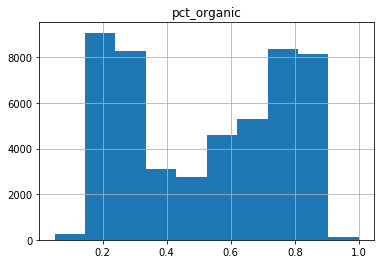

In [5]:
# import recommendation data to calculate the percent organic items in the top 20 recommendations for each user

# only 50000 users because of time constraints
df_recs = pd.read_csv('top20_products_recom.csv')
df_recs.drop(['Unnamed: 0'],axis=1,inplace=True)
display(df_recs.head(5))

#group by organic column to get the sum of organic items in top 20 recs
user_pct_organic = df_recs[['user_id','organic']].groupby('user_id').sum()\
                        .rename({'organic':'pct_organic'},axis=1)/20
display(user_pct_organic.hist()) #very bimodal.
user_pct_organic.reset_index(inplace=True)

df = df.merge(user_pct_organic,on='user_id')
display(df)

In [6]:
# project items by department into lower dimensional space using PCA
dept_cols = [colname for colname in df.columns.values if 'department' in colname] # include departments
dept_cols.remove("('department', 'missing')")# remove erroneous departments

num_pcs = 4 #select PCs with eigenvalues > 0.05 for relevance
pca = PCA(n_components=num_pcs)
pca.fit(df[dept_cols])
df_pca = pd.DataFrame(pca.transform(df[dept_cols]),columns=['PC{}'.format(x) for x in range(1,num_pcs+1)],
                           index=df.index)
df = df.join(df_pca)

In [8]:
# looking at what the PCs actually represent:
print(len(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)
# print(pca.components_)
pca_comps = pd.DataFrame(pca.components_, columns=dept_cols)
# display(pca_comps)
pca_comps = pca_comps.transpose()
pca_comps.columns = ['PC{}'.format(x) for x in range(1,num_pcs+1)]
# display(pca_comps)

print('Principal component loadings, only abs>0.3')
for pcn,pc in enumerate(pca_comps.columns.values):
    print('PC{} ({}%)'.format(pcn+1,100*pca.explained_variance_ratio_[pcn]))
    pc_i = pd.DataFrame(pca_comps[pc])
    pc_i.loc[:,pc+'_abs'] = np.abs(pc_i[pc])
#     display(pc_i.sort_values(pc+'_abs',ascending=False))
    display(pc_i.loc[pc_i[pc+'_abs']>0.3].sort_values(pc+'_abs',ascending=False))

4
[0.45843677 0.13874772 0.08017576 0.05898979]
Principal component loadings, only abs>0.3
PC1 (45.843677021027375%)


,PC1,PC1_abs
"('department', 'produce')",0.950559,0.950559


PC2 (13.874772077632185%)


,PC2,PC2_abs
"('department', 'dairy eggs')",0.691317,0.691317
"('department', 'snacks')",0.466111,0.466111


PC3 (8.017576069688257%)


,PC3,PC3_abs
"('department', 'snacks')",0.674029,0.674029
"('department', 'dairy eggs')",-0.631525,0.631525
"('department', 'beverages')",0.322139,0.322139


PC4 (5.898979386474735%)


,PC4,PC4_abs
"('department', 'frozen')",0.88571,0.88571


In [9]:
# Rename PC predictors based on interpretation
df.rename({'PC1':'produce',
           'PC2':'dairyeggs_snacks',
           'PC3':'snacks_beverages_notdairyeggs',
           'PC4':'frozen_notsnacks'},axis=1,inplace=True)

# Model framework and validation setup

In [26]:
# Validation of model using built-in methods
def print_scores(X,y,model):
    print('Precision:')
    print(metrics.precision_score(y.astype(int),model.predict(X).astype(int)))
    print('Recall:')
    print(metrics.recall_score(y.astype(int),model.predict(X).astype(int)))
    print('F1 score (0.3):')
    print(metrics.f1_score(y.astype(int),(model.predict_proba(X)[:,1]>0.3).astype(int)))
    print('F1 score (0.4):')
    print(metrics.f1_score(y.astype(int),(model.predict_proba(X)[:,1]>0.4).astype(int)))
    print('F1 score (0.5):')
    print(metrics.f1_score(y.astype(int),(model.predict_proba(X)[:,1]>0.5).astype(int)))
    print('F1 score (0.6):')
    print(metrics.f1_score(y.astype(int),(model.predict_proba(X)[:,1]>0.6).astype(int)))
    print('Mean accuracy:')
    print(model.score(X,y))
    print('ROC AUC score:')
    print(metrics.roc_auc_score(y.astype(int),model.predict(X).astype(int)))
    print('Confusion matrix:')
    print(metrics.confusion_matrix(y, model.predict(X)))
    
    print('ROC curve')
    fpr, tpr, threshes = metrics.roc_curve(y.astype(int),model.predict_proba(X)[:,1])
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()
#     print(threshes)

In [44]:
# train the classifier on 80% of the data

y_col = 'any_organic_produce'

# Testing out different feature combinations:
# feature_cols = ['any_organic_produce_prev']
# feature_cols = ['any_organic_produce_prev',
#                 'days_since_5-8','days_since_9-15','days_since_16-22','days_since_23-30',
#                 'num_past_orders',
#                 'weekend','morning']
#                 'pct_organic',
#                 'produce','dairyeggs_snacks','snacks_beverages_notdairyeggs','frozen_notsnacks']
# feature_cols = ['any_hist_organic_produce']
# feature_cols = ['any_organic_produce_prev','any_hist_organic_produce','pct_organic',]
# feature_cols = ['any_hist_organic_produce','pct_organic',]

# Final features
feature_cols = ['any_organic_produce_prev','pct_organic',]
print('Features:')
print(feature_cols)

X_train, X_test, y_train, y_test = train_test_split(
    df[feature_cols], df[y_col], test_size=0.20, random_state=22)

Features:
['any_organic_produce_prev', 'pct_organic']


# Classification tree model

[('any_organic_produce_prev', 0.7945293606408022), ('pct_organic', 0.20547063935919785)]
test data:
Precision:
0.7720574859014008
Recall:
0.768562115175661
F1 score (0.3):
0.7926177756192326
F1 score (0.4):
0.7926177756192326
F1 score (0.5):
0.7703058353752608
F1 score (0.6):
0.7703058353752608
Mean accuracy:
0.7469
ROC AUC score:
0.7443748494592015
Confusion matrix:
[[3225 1253]
 [1278 4244]]
ROC curve


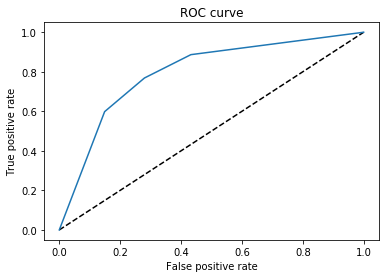

training data:
Precision:
0.7783932249942779
Recall:
0.7731550948028918
F1 score (0.3):
0.7955479591421479
F1 score (0.4):
0.7955479591421479
F1 score (0.5):
0.7757653177608468
F1 score (0.6):
0.7757653177608468
Mean accuracy:
0.75425
ROC AUC score:
0.7521575996033674
Confusion matrix:
[[13166  4841]
 [ 4989 17004]]
ROC curve


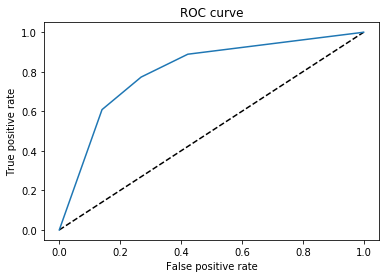

Tree:


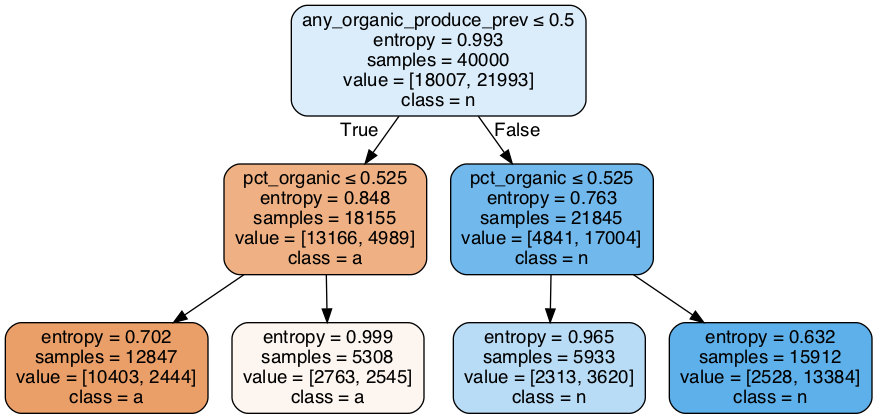

In [45]:
# classification tree
rt = tree.DecisionTreeClassifier(max_depth=2,random_state=0,criterion='entropy')
rt.fit(X_train,y_train)

print(list(zip(feature_cols,rt.feature_importances_)))

print('test data:')
print_scores(X_test,y_test,rt)

print('training data:')
print_scores(X_train,y_train,rt)

print('Tree:')
dot_data = tree.export_graphviz(rt, out_file=None, 
                         feature_names=feature_cols,  
                         class_names=y_col,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data) 

display(Image(graph.create_png()))

# Logistic regression model

test data:
Precision:
0.7471984179301252
Recall:
0.8210793190872873
F1 score (0.3):
0.79383429672447
F1 score (0.4):
0.7920578217163745
F1 score (0.5):
0.7823986194995686
F1 score (0.6):
0.7445641527913809
Mean accuracy:
0.7478
ROC AUC score:
0.7392578373015714
Confusion matrix:
[[2944 1534]
 [ 988 4534]]
ROC curve


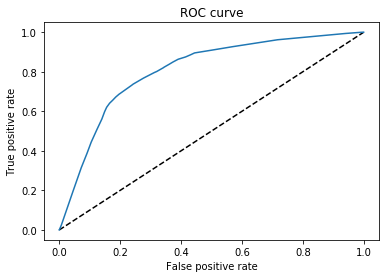

training data:
Precision:
0.7503700657894737
Recall:
0.8297640158232165
F1 score (0.3):
0.7940303330169436
F1 score (0.4):
0.7951219512195122
F1 score (0.5):
0.7880724634551854
F1 score (0.6):
0.7500675758692715
Mean accuracy:
0.754625
ROC AUC score:
0.7463086753187277
Confusion matrix:
[[11936  6071]
 [ 3744 18249]]
ROC curve


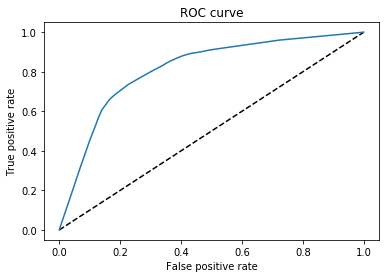

In [46]:
logisticRegr = LogisticRegression(penalty='l1',solver='liblinear')
logisticRegr.fit(X_train,y_train)

predictions = logisticRegr.predict(df[feature_cols])
df['predicted_'+y_col] = predictions
# display(df[['predicted_'+y_col,y_col]])

print('test data:')
print_scores(X_test,y_test,logisticRegr)

print('training data:')
print_scores(X_train,y_train,logisticRegr)

#                       Predicted not-y,0   Predicted y,1
# True not-y,0
# True y,1

In [48]:
# How many new produce buyers are predicted using this model?
new_predicted_buyers = df[['predicted_'+y_col,'any_organic_produce_prev']]
# display(new_predicted_buyers.sample(20))
new_predicted_buyers = new_predicted_buyers.loc[(new_predicted_buyers['predicted_'+y_col]==True)&
                                                (new_predicted_buyers['any_organic_produce_prev']==False)]

#3110 people for final model
print(len(new_predicted_buyers))
print(len(df.loc[df['predicted_'+y_col]]))
print('{}% new predicted buyers'.format(100*len(new_predicted_buyers)/len(df.loc[df['predicted_'+y_col]])))
# 0 otherwise!

3110
30388
10.234303014347768% new predicted buyers


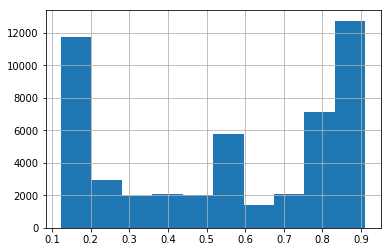

In [49]:
# disribution of predicted probabilities is trimodal.
pd.Series(logisticRegr.predict_proba(df[feature_cols])[:,1]).hist()

In [50]:
# show coefficents and odds ratios / change in probability per change in unit of feature
coefs = pd.DataFrame(list(zip(logisticRegr.coef_[0], feature_cols)),columns=['coef','feature'])
coefs['odds_ratio'] = np.exp(coefs['coef'])
coefs['delta_prob'] = coefs['odds_ratio']/(1+coefs['odds_ratio'])
display(coefs.sort_values('coef'))
# Note that pct_organic is a fraction (0-1), 
#  so 1 unit change there represents change from 0% recommendations organic to 100%

,coef,feature,odds_ratio,delta_prob
0,1.783967,any_organic_produce_prev,5.953427,0.856186
1,2.639848,pct_organic,14.011080,0.933383


In [51]:
# export big model to pickle file
filename = 'saved_models/model_final.pkl'
pickle.dump(logisticRegr, open(filename, 'wb'))

#check export worked
loaded_model = pickle.load(open(filename, 'rb'))
print(loaded_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [50]:
# F1 score of all 1s (no targeting)
print('F1 score of all 1s, test:')
print(metrics.f1_score(y_test.astype(int),np.ones(len(y_test))))
print('F1 score of all 1s, train:')
print(metrics.f1_score(y_train.astype(int),np.ones(len(y_train))))

F1 score of all 1s, test:
0.707843390618943
F1 score of all 1s, train:
0.7104469913116367


# Working on final fitted model to export columns for front-end

In [5]:
#Work from here below to work on fitted model if unnecessary to re-fit model above
filename = 'saved_models/model_final.pkl'
loaded_model = pickle.load(open(filename, 'rb'))
print(loaded_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [52]:
# Add columns of user names,emails, and probabilities for the dropdown menu and for displaying
logisticRegr = loaded_model
print(logisticRegr.classes_) #second column is True
df['predicted_prob'] = logisticRegr.predict_proba(df[feature_cols])[:,1]
df['user_dropdown'] = df.apply(lambda x: f"User {x['user_id']} (p={x['predicted_prob']:.2f})",axis=1)
df['user_emails'] = df.apply(lambda x: f"User {x['user_id']} <user{x['user_id']}@email.com)",axis=1)
df = df.sort_values(by='predicted_prob',ascending=False)
display(df)

[False  True]


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_id_order,user_id_prevorder,order_id_prev,...,num_past_orders,pct_organic,produce,dairyeggs_snacks,snacks_beverages_notdairyeggs,frozen_notsnacks,predicted_any_organic_produce,predicted_prob,user_dropdown,user_emails
30337,2879316,47720,train,32,3,10,7.0,47720.032,47720.031,2478882.0,...,31,1.00,1.671995,-1.489167,-0.237608,0.864372,True,0.910946,User 47720 (p=0.91),User 47720 <user47720@email.com)
8662,2324363,13558,train,33,3,10,9.0,13558.033,13558.032,1490352.0,...,32,1.00,-0.889453,0.177158,-1.172965,0.558379,True,0.910946,User 13558 (p=0.91),User 13558 <user13558@email.com)
38878,1194477,61197,train,23,0,16,8.0,61197.023,61197.022,2145877.0,...,22,1.00,-1.159432,-0.574821,-1.375005,-0.444023,True,0.910946,User 61197 (p=0.91),User 61197 <user61197@email.com)
8029,1511784,12585,train,35,6,14,2.0,12585.035,12585.034,940136.0,...,34,0.95,-1.155473,-0.343437,-0.089805,-0.502231,True,0.899642,User 12585 (p=0.90),User 12585 <user12585@email.com)
45691,1725202,71884,train,100,1,10,4.0,71884.100,71884.099,57098.0,...,99,0.95,3.212501,-2.135095,1.666546,-1.184706,True,0.899642,User 71884 (p=0.90),User 71884 <user71884@email.com)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46727,1541343,73515,train,5,5,19,0.0,73515.005,73515.004,3264424.0,...,4,0.10,-3.486165,-1.245050,-0.280230,0.107778,False,0.137693,User 73515 (p=0.14),User 73515 <user73515@email.com)
37615,152828,59205,train,35,3,7,9.0,59205.035,59205.034,1268615.0,...,34,0.10,-2.245204,1.877199,-1.596862,0.708560,False,0.137693,User 59205 (p=0.14),User 59205 <user59205@email.com)
10587,1878514,16567,train,19,1,11,5.0,16567.019,16567.018,672125.0,...,18,0.10,-2.440030,-0.468440,1.469013,-0.877077,False,0.137693,User 16567 (p=0.14),User 16567 <user16567@email.com)
12865,27660,20115,train,23,5,5,15.0,20115.023,20115.022,2359352.0,...,22,0.05,0.816830,2.638052,0.728615,1.706994,False,0.122757,User 20115 (p=0.12),User 20115 <user20115@email.com)


In [53]:
# save df for displaying in front end
df.to_csv('modeling_dfs/final_users_50k.csv')

In [21]:
# What percent organic were user's recommendations, on average?
df['pct_organic'].describe()

count    50000.000000
mean         0.524672
std          0.258065
min          0.050000
25%          0.250000
50%          0.550000
75%          0.800000
max          1.000000
Name: pct_organic, dtype: float64